# Iteration 5<br/>*Feature Extraction*

Jupyter Notebook referenced from my website: [Feature Extraction](https://sdiehl28.netlify.com/projects/iterative_model_dev/titanic05/)

### Goals
1. In the first iteration of model building, several feature extraction ideas were presented. See: [EDA](http://nbviewer.jupyter.org/github/sdiehl28/tutorial-jupyter-notebooks/blob/master/projects/titanic/Titanic01.ipynb#eda)
2. Implement these.
3. As part of iterative model development, compare performance with previous iterations.

### Where We Are
In the previous iteration, we made use two categorical variables, Embark and Sex, by one hot encoding them.  This improved the model's accuracy.

### What's Next
In the first iteration, during EDA, we made several notes on what to try next.  These were:
1. Extract binary categorical features: alone, sibsp_zero, parch_zero
2. Extract ordered categorical feature: fare_quantized
5. Standardize
6. Compute Cross Validated Model Scores 

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

### Previous Iteration Setup
Previous Iteration: [Categorical Encoding](http://nbviewer.jupyter.org/github/sdiehl28/tutorial-jupyter-notebooks/blob/master/projects/titanic/Titanic04.ipynb) 

In [2]:
# Equivalent to previous iteration
# Refactored to be more concise

# read in all the labeled data
all_data = pd.read_csv('./data/train.csv')

# drop string columns with too many values or too many nulls
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
all_data = all_data.drop(drop_cols, axis=1)

# drop rows with Embarked null
rows_to_keep = all_data['Embarked'].notnull()
all_data = all_data[rows_to_keep]

# one-hot encode Sex and Embarked
gender = pd.get_dummies(all_data['Sex'], drop_first=True, prefix='gender')
port = pd.get_dummies(all_data['Embarked'], drop_first=True, prefix='port')
all_data = pd.concat([all_data, gender, port], axis=1)

# remove encoded variables
all_data.drop(['Embarked', 'Sex'], axis=1, inplace=True)

### Extract New Features

In [3]:
# proposed feature extraction: sibsp == 0
all_data['sibsp_zero'] = (all_data['SibSp'] == 0)

# proposed feature extraction: parch == 0
all_data['parch_zero'] = (all_data['Parch'] == 0)

# proposed feature extraction: sibsp == 0 & parch == 0
all_data['alone'] = (all_data['parch_zero'] & all_data['sibsp_zero'])

# proposed feature extraction: quantize fare
def quantize_fare(fare):
    if fare < 45:
        return 0
    elif fare < 80:
        return 1
    else:
        return 2
    
all_data['fare_quantized'] = all_data['Fare'].apply(quantize_fare)
all_data.head(3)

,Survived,Pclass,Age,SibSp,Parch,Fare,gender_male,port_Q,port_S,sibsp_zero,parch_zero,alone,fare_quantized
0,0,3,22.0,1,0,7.2500,1,0,1,False,True,False,0
1,1,1,38.0,1,0,71.2833,0,0,0,False,True,False,1
2,1,3,26.0,0,0,7.9250,0,0,1,True,True,True,0


In [4]:
# break up the dataframe into X and y
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']

### Scikit Learn Imports

In [5]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

### SetUp Scoring Evaluation

In [6]:
k_folds = 10
random_seed=5
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

### Transform Class
Copied from previous iterations, except modified to use gender_male instead of Sex.

In [7]:
# Custom Transform Class for Imputation
from sklearn.base import TransformerMixin
class MyTransformer(TransformerMixin): 
    '''Class with fit() and transform() methods'''

    def fit(self, X, y):
        '''
        fit() will compute and save the mean age per (pclass, sex)
        on the training data
        '''
        self.mean_age_by_pclass_sex = X.groupby(['Pclass', 'gender_male'])['Age'].mean()
        
        # return an instance of MyTransformer
        return self
    
    def transform(self, X):
        '''
        transform() is applied to both train and test data
        
        It will replace missing age values by looking up the
        mean age per (pclass,sex)
        '''
        
        # index into multi-indexed Pandas Series using 2-part key
        # Pandas does not allow indexing by DataFrame, so create list of tuples
        # each tuple is (pclass, sex)
        missing_age_idx = X['Age'].isnull()
        df = X.loc[missing_age_idx, ['Pclass', 'gender_male']]
        index_tuples = list(df.itertuples(index=False, name=None))
        
        # lookup mean age in DataFrameGroupBy using list of tuples of (pclass, sex)
        imputed_age_values = self.mean_age_by_pclass_sex.loc[index_tuples].values
        
        # replace the missing values with the imputed age values
        X = X.copy()
        X.loc[missing_age_idx, 'Age'] = imputed_age_values

        # drop the sex column as logicstic regression only works with numerics
        # (later we will encode it and use it)
        return X

In [8]:
standard_scaler = StandardScaler()
my_transformer = MyTransformer()

classifier = make_pipeline(my_transformer, standard_scaler, LogisticRegression())

scores = cross_val_score(classifier, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=1)

# save scores for comparison with another iteration
np.save("./data/iter05.data", scores)

print(np.round(scores,3))
print(round(np.mean(scores),3))

[0.809 0.764 0.787 0.876 0.888 0.809 0.831 0.809 0.787 0.795]
0.816


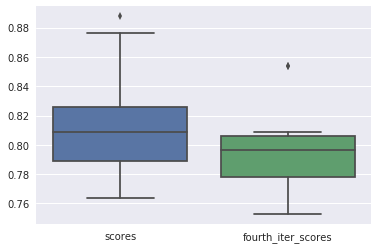

In [9]:
# Read in scores from previous iteration
fourth_iter_scores = np.load('./data/iter04.data.npy')

df = pd.DataFrame(data=list(zip(scores, fourth_iter_scores)),
                  columns=['scores','fourth_iter_scores'])
sns.boxplot(data=df)
plt.savefig(fname='5_vs_4.png', dpi=120)

In [10]:
# the scores in the ordered list correspond with each other as they were
# perform on the same train/test split
diff_scores = scores - fourth_iter_scores
print(np.round(sorted(diff_scores),3))

[-0.011  0.     0.     0.011  0.011  0.011  0.022  0.022  0.034  0.056]


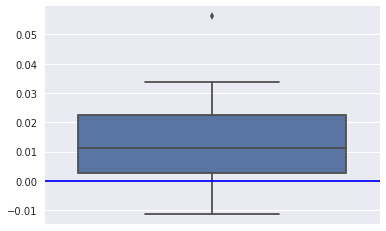

In [11]:
# boxplot the differences and highlight x-axis
sns.boxplot(y=diff_scores)
plt.axhline(0, color='blue')

In [12]:
# How many times is the new model better?
print(f'New Model wins:  {(diff_scores > 0).sum()}')
print(f'New Model ties:  {(diff_scores == 0).sum()}')
print(f'New Model loses: {(diff_scores < 0).sum()}')

New Model wins:  7
New Model ties:  2
New Model loses: 1


From the above boxplot and individual comparison of the scores, it appears the new model is slightly better. The change we made was to extract new features and standardize the features.

### Model Summary
Model Building Steps Only

In [13]:
# Equivalent to previous iteration
# Refactored to be more concise

# read in all the labeled data
all_data = pd.read_csv('./data/train.csv')

# drop string columns with too many values or too many nulls
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
all_data = all_data.drop(drop_cols, axis=1)

# drop rows with Embarked null
rows_to_keep = all_data['Embarked'].notnull()
all_data = all_data[rows_to_keep]

# one-hot encode Sex and Embarked
gender = pd.get_dummies(all_data['Sex'], drop_first=True, prefix='gender')
port = pd.get_dummies(all_data['Embarked'], drop_first=True, prefix='port')
all_data = pd.concat([all_data, gender, port], axis=1)

# remove encoded variables
all_data.drop(['Embarked', 'Sex'], axis=1, inplace=True)

# feature extraction: sibsp == 0
all_data['sibsp_zero'] = (all_data['SibSp'] == 0)

# feature extraction: parch == 0
all_data['parch_zero'] = (all_data['Parch'] == 0)

# feature extraction: sibsp == 0 & parch == 0
all_data['alone'] = (all_data['parch_zero'] & all_data['sibsp_zero'])

# feature extraction: quantize fare
def quantize_fare(fare):
    if fare < 45:
        return 0
    elif fare < 80:
        return 1
    else:
        return 2
    
all_data['fare_quantized'] = all_data['Fare'].apply(quantize_fare)

k_folds = 10
random_seed=5
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

standard_scaler = StandardScaler()
my_transformer = MyTransformer()

classifier = make_pipeline(my_transformer, standard_scaler, LogisticRegression())

scores = cross_val_score(classifier, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=1)

print(np.round(scores,3))
print(round(np.mean(scores),3))

[0.809 0.764 0.787 0.876 0.888 0.809 0.831 0.809 0.787 0.795]
0.816


In [14]:
# previous model
print(f'Previous Cross Validated Accuracy: {fourth_iter_scores.mean() :.3f}')

Previous Cross Validated Accuracy: 0.800


### Notebook Summary
In this iteration we:
* Added the features suggested in the first iteration of model building
* Measured the new model's accuracy and found it to be slightly better (81.6% vs 80.0%)